# Compare outputs of MST and SMel models (Figure 3) 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import librosa
import glob
kernel = 0
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../..')

from sed_endtoend.optimizer import *
from sed_endtoend.callbacks import *
from sed_endtoend.mst.model import MST
from sed_endtoend.smel.model import SMel
from sed_endtoend.data_generator import DataGenerator, Scaler
from sed_endtoend.gen_mel_filters import mel_filters
from keras.callbacks import CSVLogger

os.environ["CUDA_VISIBLE_DEVICES"]="0"

from params import *

# files parameters
Nfiles = 100
resume = False
load_subset = Nfiles

Using TensorFlow backend.


Founding scaler
Making generators
Getting data

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 22050, 1)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 44, 512)           524800    
_________________________________________________________________
batch_normalization_10 (Batc (None, 44, 512)           2048      
_________________________________________________________________
activation_10 (Activation)   (None, 44, 512)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 44, 256)           393472    
_________________________________________________________________
batch_normalization_11 (Batc (None, 44, 256)           1024      
_________________________________________________________________
activation

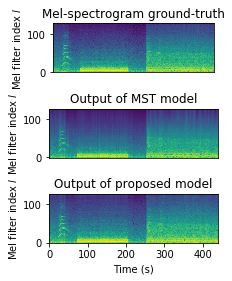

In [5]:
params = {'sequence_time': sequence_time, 'sequence_hop_time':sequence_hop_time,
          'label_list':label_list,'audio_hop':audio_hop, 'audio_win':audio_win,
          'n_fft':n_fft,'sr':sr,'mel_bands':mel_bands,'normalize':normalize_data, 
          'frames':frames,'get_annotations':get_annotations, 'dataset': dataset}
sequence_frames = int(np.ceil(sequence_time*sr/audio_hop))

# Datasets
partition = {}# IDs
labels = {}# Labels

test_files = sorted(glob.glob(os.path.join(feature_folder,'test', '*.wav')))
val_files = sorted(glob.glob(os.path.join(feature_folder,'validate', '*.wav')))

file=10
if load_subset is not None:
    test_files = test_files[file:file+1]
    val_files = val_files[file:file+1]

test_labels = {}
test_mel = {}
val_labels = {}
val_mel = {}
print('Founding scaler')
for n,id in enumerate(test_files):
    labels[id] = os.path.join(label_folder, 'test',os.path.basename(id).replace('.wav','.txt'))
for id in val_files:
    labels[id] = os.path.join(label_folder, 'validate',os.path.basename(id).replace('.wav','.txt'))

params['sequence_hop_time'] = sequence_time
   
print('Making generators')
test_generator = DataGenerator(test_files, labels, **params)
validation_generator = DataGenerator(val_files, labels, **params)
  
scaler = Scaler(normalizer=normalize_data)
scaler_vector = np.load(os.path.join(expfolder, '../../sed_endtoend/scaler.npy')) 
scaler.set_scaler(scaler_vector)

print('Getting data')

x_val,_,mel_val,_ = validation_generator.return_all()
x_test,_,mel_test,_ = test_generator.return_all()

mel_test = scaler.transform(mel_test)
mel_val = scaler.transform(mel_val)


params['frames'] = True
test_generator = DataGenerator(test_files, labels, **params)
x_test_frames,_,_,_ = test_generator.return_all()

sequence_frames = x_test_frames.shape[1]

# Build model

print('\nBuilding model...')

sequence_samples = int(sequence_time*sr)

model = MST(mel_bands,sequence_samples,audio_win,audio_hop)

model.summary()

weights_best_file = '../../sed_endtoend/mst/weights_best.hdf5'
model.load_weights(weights_best_file)

predict1 = model.predict(x_test)
   

model = SMel(mel_bands,sequence_frames,audio_win,audio_hop,scaler=None)    

model.summary()

weights_best_file = '../../sed_endtoend/smel/weights_best.hdf5'
model.load_weights(weights_best_file)

predict2 = model.predict(x_test_frames)

print(mel_test.shape,predict1.shape,predict2.shape)

mel_test=np.concatenate(mel_test.tolist(),axis=0)
predict1=np.concatenate(predict1.tolist(),axis=0)
predict2=np.concatenate(predict2.tolist(),axis=0)

print(mel_test.shape,predict1.shape,predict2.shape)

#t = np.linspace(0,10,mel_test[0])

#np.save('mel_test.npy',mel_test)
#np.save('predict1.npy',predict1)
#np.save('predict2.npy',predict2)


fig,axes = plt.subplots(ncols=1, nrows=3)
#
axes[0].set_title('Mel-spectrogram ground-truth')
axes[0].imshow(mel_test.T,origin='lower',cmap=plt.cm.viridis)
axes[0].set_xticks([])
axes[0].set_ylabel('Mel filter index $l$')
#
axes[1].set_title('Output of MST model')
axes[1].imshow(predict1.T,origin='lower',cmap=plt.cm.viridis)
axes[1].set_xticks([])
axes[1].set_ylabel('Mel filter index $l$')
#
axes[2].set_title('Output of proposed model')
axes[2].imshow(predict2.T,origin='lower',cmap=plt.cm.viridis)#,extent=[0,10,0,128]
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Mel filter index $l$')
plt.tight_layout()
#plt.xticks=[]
fig.savefig('compare_outputs.eps', bbox_inches='tight')   # save the figure to file
plt.show()
plt.close(fig)